# Ejercicio 1

Realizar el ejercicio 1 de Naive Bayes y KNN con árboles de decisión.

## Creación de los datos

In [2]:
import numpy as np

np.random.seed(41)

# Clase 0
class_0_data = np.random.normal(0, 1, size=(100, 2)) # 100 filas y 2 columnas con media 0 y desviación 1
class_0_labels = np.zeros(100) # 100 ceros

# Clase 1
class_1_data = np.random.normal(3, 1, size=(100, 2)) # 100 filas y 2 columnas con media 3 y desviación 1
class_1_labels = np.ones(100) # 100 unos

In [3]:
import pandas as pd

# Formateo y combinación de los datos
X = np.vstack((class_0_data, class_1_data)) # Apilamos los datos verticalmente
y = np.concatenate((class_0_labels, class_1_labels)) # Concatenamos los labels de las clases

# Creación del los dataframes
df_class = pd.DataFrame(X, columns=['Columna_1', 'Columna_2']) # Creamos un dataframe con los datos
df_target = pd.DataFrame(y, columns=['Target']) # Creamos un dataframe con los labels

# Unimos los 2 dataframes y el target se modifica a tipo int para knn
df_complete = pd.concat([df_class, df_target], axis=1)
df_complete.Target = df_complete.Target.astype(int)

df_complete.head()

,Columna_1,Columna_2,Target
0,-0.270712,0.104848,0
1,0.250528,-0.925200,0
2,0.567144,-1.040180,0
3,-0.153676,0.789852,0
4,-1.226216,-0.948007,0


## Visualización de los datos

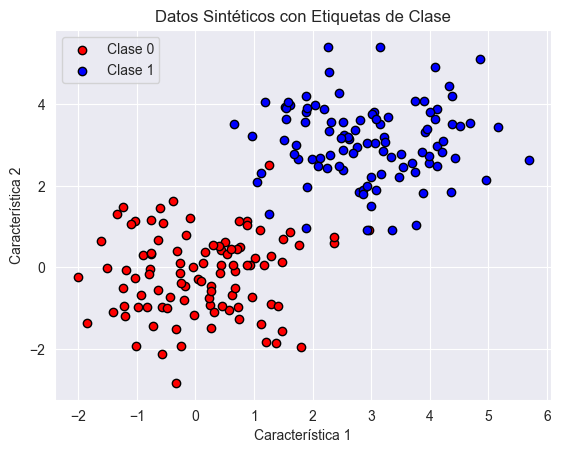

In [4]:
import matplotlib.pyplot as plt

COLORS = ('red', 'blue')

for i, data in enumerate((class_0_data, class_1_data)):
    plt.scatter(data[:, 0], data[:, 1], c=COLORS[i], edgecolor='k', label=f"Clase {i}")

plt.title('Datos Sintéticos con Etiquetas de Clase')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.legend()
plt.show()

## Visualización de la distribución de las clases

Target
0    100
1    100
dtype: int64


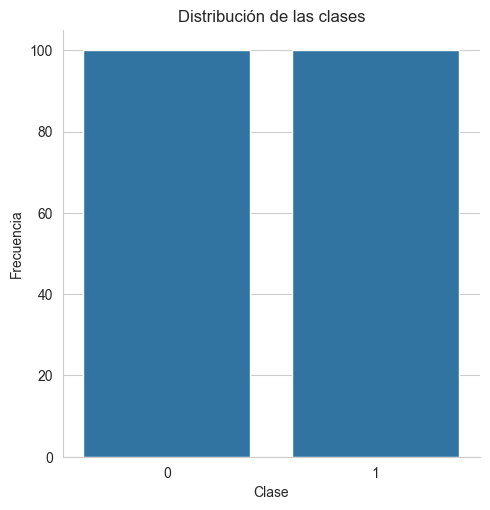

In [5]:
import seaborn as sns

sns.set_style('whitegrid')
print(df_complete.groupby('Target').size())
sns.catplot(x='Target', kind='count', data=df_complete)
plt.title('Distribución de las clases')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.show()

## Preparación del conjunto de datos

In [6]:
from sklearn.model_selection import train_test_split

p_train = 0.7

train, test = train_test_split(df_complete, train_size=p_train, random_state=42)

# inplace=True: Modifica el dataframe original en lugar de devolver uno nuevo
train.reset_index(inplace=True)
test.reset_index(inplace=True)

print(f'Train: {train.shape}') # 160 y 4 columnas
print(f'Test: {test.shape}') # 40 y 4 columnas

print("Conjunto de entrenamiento:")
print(train.head())

print("Conjunto de prueba:")
print(test.head())

Train: (140, 4)
Test: (60, 4)
Conjunto de entrenamiento:
   index  Columna_1  Columna_2  Target
0    169   3.697324   2.550794       1
1     97   2.964322   0.924850       0
2     31   1.367851  -1.858739       0
3     12   1.200060  -1.822619       0
4     35   1.165984   0.049214       0
Conjunto de prueba:
   index  Columna_1  Columna_2  Target
0     95  -1.205791  -1.190786       0
1     15   1.015425   0.224081       0
2     30   1.803952  -1.948671       0
3    158   3.917554   3.329283       1
4    128   2.928391   0.908526       1


## Validación cruzada

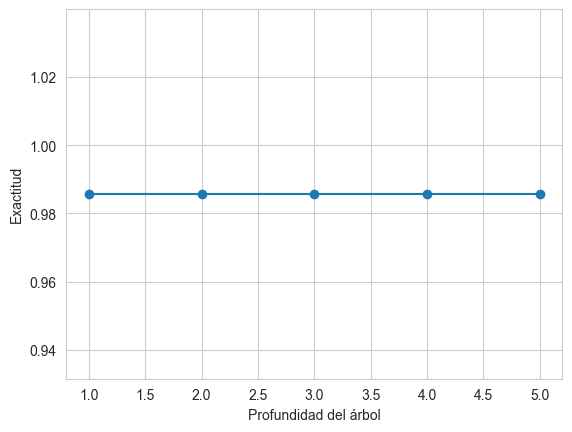

In [7]:
from sklearn import tree
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=False)
accuracies = list()
max_attributes = len(list(df_complete))
depth_range = range(1, max_attributes * 2)

# Testeamos la profundidad de los árboles
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(
        criterion='entropy',
        max_depth=depth
    )
    for train_fold, test_fold in cv.split(train):
        f_train = train.loc[train_fold] 
        f_test = train.loc[test_fold] 

        model = tree_model.fit(X=f_train.drop(['Target'], axis=1),
                               y=f_train['Target'])
        
        test_acc = model.score(X=f_test.drop(['Target'], axis=1),
                               y=f_test['Target'])
        
        fold_accuracy.append(test_acc)
        
    accuracies.append(np.mean(fold_accuracy))

# Mostramos los resultados
plt.plot(depth_range, accuracies, marker='o')
plt.xlabel('Profundidad del árbol')
plt.ylabel('Exactitud')
plt.show()

# Obtenemos la mejor profundidad
best_depth = depth_range[np.argmax(accuracies)]

## Creación del modelo

In [16]:
from sklearn.metrics import classification_report

X_train = train[['Columna_1', 'Columna_2']]
y_train = train['Target']
X_test = test[['Columna_1', 'Columna_2']]
y_test = test['Target']

# Creamos el modelo
clf = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=best_depth
)

# Entrenamos el modelo
clf.fit(X=X_train, y=y_train)

# Realizamos predicciones
y_pred = clf.predict(X_test)

# Mostramos el reporte de clasificación
print(classification_report(test['Target'], y_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94        31
           1       0.96      0.90      0.93        29

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60


## Visualización del modelo

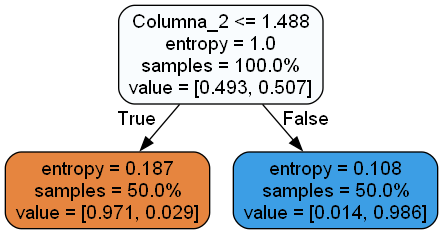

In [9]:
import pydot
from IPython.display import Image
from sklearn import tree
from io import StringIO

dot_data = StringIO()
tree.export_graphviz(
    clf,
    out_file=dot_data,
    proportion=True,
    feature_names=['Columna_1', 'Columna_2'],
    rounded=True,
    filled=True
)

graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

## Matriz de confusión

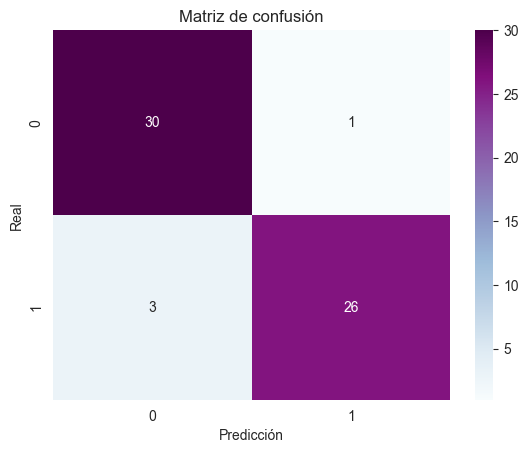

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(test['Target'], y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='BuPu')
plt.title('Matriz de confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()